In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv("True.csv")
df2 = pd.read_csv("Fake.csv")

In [3]:
df1['label'] = 1
df2['label'] = 0

In [4]:
df = pd.merge(df1,df2, suffixes = ("t","f"), how = "outer")

In [5]:
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
null_counts = df.isnull().sum()
print(null_counts)

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [7]:
df.duplicated().sum()

209

In [8]:
df.drop_duplicates(inplace = True)

In [9]:
df['label'].value_counts()

label
0    23478
1    21211
Name: count, dtype: int64

<Axes: xlabel='label'>

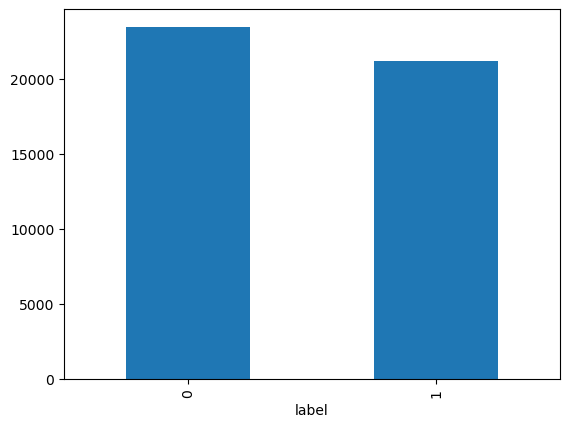

In [10]:
df['label'].value_counts().plot(kind='bar')

In [11]:
df['text'] = [str(i).lower() for i in df['text']] #normalizing data by reducing the letters to lowercase

In [12]:
X = df['text'] 
y = df['label'] 

In [13]:
X.shape

(44689,)

In [14]:
y.shape

(44689,)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
tfidf_features = tfidf_vectorizer.fit_transform(X).toarray()

print("TF-IDF Features Shape:", tfidf_features.shape)

TF-IDF Features Shape: (44689, 2000)


In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=500)
X_pca = pca.fit_transform(tfidf_features)

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=35)

rf_classifier = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=13, min_samples_leaf=4, max_features='sqrt')
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6987
           1       0.95      0.93      0.94      6420

    accuracy                           0.94     13407
   macro avg       0.94      0.94      0.94     13407
weighted avg       0.94      0.94      0.94     13407



In [20]:
param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [None, 10],  
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]  
}

from sklearn.model_selection import GridSearchCV

In [21]:
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                              min_samples_split=13,
                                              n_estimators=300),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [22]:
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

y_pred = best_rf_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      6987
           1       0.96      0.96      0.96      6420

    accuracy                           0.96     13407
   macro avg       0.96      0.96      0.96     13407
weighted avg       0.96      0.96      0.96     13407



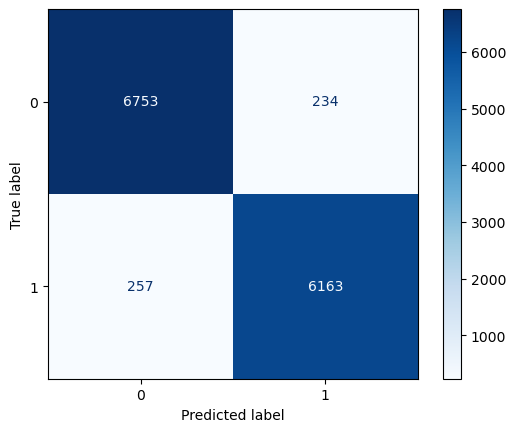

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [25]:
from sklearn.tree import DecisionTreeClassifier 
  
model = DecisionTreeClassifier() 
model.fit(X_train, y_train) 
  
# testing the model 
print(accuracy_score(y_train, model.predict(X_train))) 
print(accuracy_score(y_test, model.predict(X_test))) 

0.9999680327344799
0.9282464384276871


In [26]:
import joblib

In [27]:
# Saving the components
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer_new.pkl')
joblib.dump(pca, 'pca_new.pkl')
joblib.dump(best_rf_classifier, 'best_rf_classifier_new.pkl')

['best_rf_classifier_new.pkl']

In [50]:
def preprocess_and_predict(new_text, tfidf_vectorizer, pca, best_rf_classifier):
    new_text_tfidf = tfidf_vectorizer.transform([new_text]).toarray()
    
    new_text_pca = pca.transform(new_text_tfidf)
    
    prediction = best_rf_classifier.predict(new_text_pca)
    
    return prediction

In [51]:
# Example new text
new_text = "Benin and Sierra Leone deposited their instruments of acceptance of the Agreement on Fisheries Subsidies on 19 July, advancing the tally of formal acceptances to 80. Ambassador Corinne Brunet of Benin and Ambassador Lansana Gberie of Sierra Leone presented the instruments of acceptance to Director-General Ngozi Okonjo-Iweala."
predicted_label = preprocess_and_predict(new_text, tfidf_vectorizer, pca, best_rf_classifier)

print(f"Predicted Label: {predicted_label}")
if predicted_label[0] == 1:
    print("Real news")
elif predicted_label[0] == 0:
    print("Fake news")

Predicted Label: [1]
Real news
